In [1]:
import warnings
warnings.filterwarnings('ignore')

from os import listdir
import librosa

import numpy as np
import pandas as pd

# utility libraries
from tqdm import tqdm
import matplotlib.image as mpimg
import seaborn as sns

# Data PreProcessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Modelling libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from pylab import rcParams

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

Dal sito "https://github.com/mdeff/fma" abbiamo scaricato la cartella $fma\_ metadata.zip$ nella quale era a disposizione il file $tracks.csv$.

Nel file sono a disposizione informazioni circa l'ID, il titolo, l'artista, il genere di un dataset di 106574 canzoni.
Di seguito estrapoliamo l'ID e il genere relativi alle 8000 canzoni del nostro dataset. Tali canzoni sono individuate dall'informazione $subset$ che divide le 106574 tracce in 3 grandi insiemi: Small, Medium e Large. 

Il nostro dataset sarà identificato da $subset = small$.

In [3]:
# Carico il file tracks.csv
track_df = pd.read_csv("../data/fma_metadata/tracks.csv", index_col=False)
col = track_df.iloc[0] 
col[0] = "track_id"
track_df.columns = col
track_df = track_df.iloc[2:]
# Seleziono solo le canzoni del sottoinsieme small (saranno 8000 su 106574)
small_df=track_df[track_df['subset']=="small"] 
# Seleziono solo le colonne track_id e genre_top
small_df=small_df[["track_id", "genre_top"]] 
small_df["track_id"] = small_df["track_id"].astype(str)
small_df.reset_index(drop=True, inplace=True) 
small_df.shape

(8000, 2)

La funzione $\textit columns()$ fa le seguenti cose:

- Crea un dizionario che ha come 'chiavi' le $features$ e come 'valori' un numero pari a quanti array la specifica feature restituisce.

- Crea il vettore $moments$ con i parametri statistici. In seguito tramite la funzione $\textit feature\_stats()$ calcoleremo tali parametri per ogni array delle features.

- Crea un multiIndice su 3 livelli: nome della feature, parametro statistico, e relativo valore

In [4]:
# SI
#dict sta per dizionario, quindi una logica chiave-valore

def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items(): #feature_sizes.items() è un vettore contenente gli elementi del dizionario dict, quindi chiave e valore
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size)) #Creazione di un vettore con nome della variabile, "momento" e range (per alcune variabili ho più dati, più range)
            columns.extend(it) #Metto insieme tutti gli "it"

    names = ('feature', 'statistics', 'number') #Tipo di feature, tipo di "moments", e "range"
    columns = pd.MultiIndex.from_tuples(columns, names=names) #Creazione del multiIndex
    
    return columns.sort_values() # More efficient to slice if indexes are sorted.


Esempio di una Series con gli indici creati dalla funzione $\textit columns()$

In [5]:
features = pd.Series(index=columns(), dtype=np.float32)
features

feature      statistics  number
chroma_cens  kurtosis    01       NaN
                         02       NaN
                         03       NaN
                         04       NaN
                         05       NaN
                                   ..
zcr          mean        01       NaN
             median      01       NaN
             min         01       NaN
             skew        01       NaN
             std         01       NaN
Length: 518, dtype: float32

La funzione f𝑒𝑎𝑡𝑢𝑟𝑒_𝑠𝑡𝑎𝑡𝑠() calcola i valori statistici della features

In [6]:
#Funzione a cui passo il vettore Features, il nome della features scelta
#(ad esempio chroma_cqt o rmse o zcr) e i valori di quest'ultima

def feature_stats(features, name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)
        
        return features

La funzione $\textit load\_features$ prende in input il numero di canzoni che vogliamo caricare per ogni genere musicale e fa le seguenti cose:

- Creazione del contatore $genre\_ count$ che tiene conto durante l'esecuzione del programma del numero di canzoni caricate fino a quel momento nel ciclo. Ci servirà per la creazione di un dataset equidistribuito.

- Creazione di un dataframe vuoto $df\_ features$ che ha nelle collonne i multiIndici di $columns()$ ed anche le colonne $track\_ id$ e $genre\_ top$.

- Scorriamo nel primo ciclo 'for' dentro tutte le cartelle contenute in $fma\_ small$ e nel secondo ciclo 'for' tutte le canzoni di ogni cartella.

- Per ogni canzone prendiamo il $track\_ id$ e il $genre\_ top$. Tramite il contatore controlliamo se abbiamo abbastanza canzoni per quel fissato genere: 

    - In caso affermativo controlliamo se abbiamo abbastanza canzoni per ogni genere e in questo caso restituiamo il dataframe, altrimenti continuiamo a scorrere le canzoni. 
    - In caso negativo tramite la funzione $feature\_ stats$ calcoliamo i valori delle features della canzone che inseriamo in $features$ i cui indici sono creati con la funzione columns.
    - Aggiungiamo $features$ a $df\_ features$ e aggiorniamo il contatore. 

In [7]:
from IPython.display import clear_output

def load_features(song_per_genre):
    genre_count = { 'Hip-Hop' : 0, 'Pop' : 0, 'Experimental' : 0, 'Rock' : 0, 
               'International' : 0, 'Electronic' : 0, 'Instrumental' : 0 , 'Folk' : 0 }

    all_folders = listdir("../data/fma_small/")[:-2] # lista di tutte le cartelle con le canzoni

    dfTrackGenre=pd.DataFrame(columns=['track_id', 'genre_top']) #Creo un dataframe con colonne track_id e genre_top
    df_features = pd.DataFrame(columns=columns() ) #Creo un dataframe con colonne create nella funzione "columns"
    df_features=pd.concat([df_features,dfTrackGenre], axis=1) #Concateno i 2 dataframe

    # Scorriamo tutte le canzoni in tutte le cartelle:
    for fold in all_folders: 
        for song in listdir("../data/fma_small/" + fold):

            try:

                current_track = str(int(song[:-4])) #Salvo il track_id della canzone (il -4 è per eliminare il.mp3, int per eliminare gli zeri e str per convertirlo in stringa)
                current_genre = small_df[small_df["track_id"]==current_track].iloc[0,1] #Salvo il genere rispetto a quell'id

                if genre_count[current_genre]>=song_per_genre: # Se non ci sono abbatanza canzoni per quel genere va avanti (altrimenti skippa)
                    if min(genre_count.values()) == song_per_genre: # Se ci sono abbastanza per ogni genere ritorna il dataframe
                        return df_features
                    else: 
                        continue

                features = pd.Series(index=columns(), dtype=np.float32) #Crea una "Series" che poi concatenerò al df

                x, sr = librosa.load("../data/fma_small/" + fold + "/" + song)

                f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
                features= feature_stats(features, 'zcr', f)

                cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                         n_bins=7*12, tuning=None))
                assert cqt.shape[0] == 7 * 12
                assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

                f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
                features= feature_stats(features, 'chroma_cqt', f)

                f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
                features= feature_stats(features, 'chroma_cens', f)

                f = librosa.feature.tonnetz(chroma=f)
                features= feature_stats(features, 'tonnetz', f)
                del cqt

                stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))

                assert stft.shape[0] == 1 + 2048 // 2
                assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
                del x

                f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
                features= feature_stats(features, 'chroma_stft', f)

                f = librosa.feature.rms(S=stft)
                features= feature_stats(features, 'rmse', f)

                f = librosa.feature.spectral_centroid(S=stft)
                features= feature_stats(features, 'spectral_centroid', f)

                f = librosa.feature.spectral_bandwidth(S=stft)
                features= feature_stats(features, 'spectral_bandwidth', f)

                f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
                features= feature_stats(features, 'spectral_contrast', f)

                f = librosa.feature.spectral_rolloff(S=stft)
                features= feature_stats(features, 'spectral_rolloff', f)

                mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
                del stft

                f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
                features= feature_stats(features, 'mfcc', f)

                features=pd.DataFrame(features)
                features=features.T
                features=pd.concat([features,dfTrackGenre], axis=1)

                features["track_id"] = [int(current_track)]*features.shape[0]
                features["genre_top"] = [current_genre]*features.shape[0]

                # df_features=df_features.append(features)
                df_features = pd.concat([df_features, features], ignore_index=True)

                genre_count[current_genre] += 1

                clear_output()
                display(genre_count)

            except Exception as e:
                print("ERRORE QUA >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", e, fold, song)
    return df_features

In [8]:
# Contemporaneamente carico le canzoni e creo la matrice delle features
feat_df = load_features(1000)
# Rinomino gli indici delle righe
feat_df = feat_df.reset_index(drop=True)
# Salvo la matrice
feat_df.to_csv("../data/df_features.csv", index=False)

{'Hip-Hop': 997,
 'Pop': 1000,
 'Experimental': 999,
 'Rock': 999,
 'International': 1000,
 'Electronic': 999,
 'Instrumental': 1000,
 'Folk': 1000}

In [9]:
#Load della matrice che ho salvato sopra
feat_df = pd.read_csv('../data/df_features.csv', index_col=False)

In [10]:
feat_df.shape

(7994, 520)

$$ Training \ e \ Test \ set $$

Dividiamo il dataset in Training e Test Set in modo equidistribuito.

In [11]:
features=feat_df.drop(["track_id","genre_top"], axis=1)
target=feat_df["genre_top"]

train_x, test_x, train_y, test_y = train_test_split(features, target, stratify=target, 
                                                    shuffle=True , test_size=0.2002, 
                                                    random_state=0)

print('Train:', train_x.shape, train_y.shape)
print('Test:', test_x.shape, test_y.shape)

Train: (6393, 518) (6393,)
Test: (1601, 518) (1601,)


$$ SOSTITUISCO \ I \ VALORI \ MANCANTI \ CON \ LA \ MEDIA $$

In [12]:
# Calculate the mean of train_x columns
train_x_means = train_x.mean()

# Fill nulls in train_x in place
train_x.fillna(train_x_means, inplace=True)

# Fill nulls in train_y in place using train_x's column means
test_x.fillna(train_x_means, inplace=True)

$$ NORMALIZZIAMO \ I \ DATI $$

In [13]:
# Normalizziamo i dati, StandardScaler
scaler = StandardScaler()
scaler.fit(train_x) # ATTENTIONE! SI USA LA MEDIA E VARIANZA DEL TRAINING SET
# creo dei dataframe
train_x=pd.DataFrame(scaler.transform(train_x))
test_x=pd.DataFrame( scaler.transform(test_x))

Prima di dare in pasto il training set ai classificatori, abbiamo analizzato i dati per capire se era opportuno modificare il dataset per estrapolare più informazioni possibili. L’analisi dei dati che ora spieghiamo,  è stata fatta sugli elementi del training set.

$$ MATRICE \ DI \ CORRELAZIONE $$

Come prima cosa abbiamo calcolato la matrice di correlazione e dai risultati ci siamo accorti della eccessiva dipendenza lineare di alcune features. Questo ci ha portato subito a pensare che potevamo ridurre la dimensionalità del dataset in modo da rendere i modelli di classificazione più snelli e più facili da addestrare. 

Per ridurre la dimensionalità potremmo togliere le features che sono troppo dipendenti tra di loro (ovvero se 2 features hanno $ \rho \ tale \ che :$ $|\rho|\geq 0.9$ allora tolgo una tra queste), ma invece abbiamo deciso di usare altri metodi che vedremo di seguito.

Di seguito calcoliamo la matrice di correlazione e contiamo le features potremmo togliere con il criterio appena descritto.

Ricordiamo che nella posizione $(i,j)$ della matrice di correlazione c'è coefficiente di correlazione (lineare) tra le feature $i$ e $j$. Valore in $[-1,1]$: $1$ correlazione perfetta, $-1$ correlazione inversa perfetta, $0$ assenza di correlazione:
$$ \rho_{XY}=\frac {Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}  $$

In [14]:
corr_matrix = train_x.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(f"Il numero di colonne troppo correlate è: {len(to_drop)}")

cor = pd.DataFrame(corr_matrix, index = train_x.columns, columns = train_x.columns)

# Drop features 
train_x.drop(to_drop, axis=1, inplace=True)
test_x.drop(to_drop, axis=1, inplace=True)


Il numero di colonne troppo correlate è: 96


Text(0.5, 1.0, 'Matrice Correlazione')

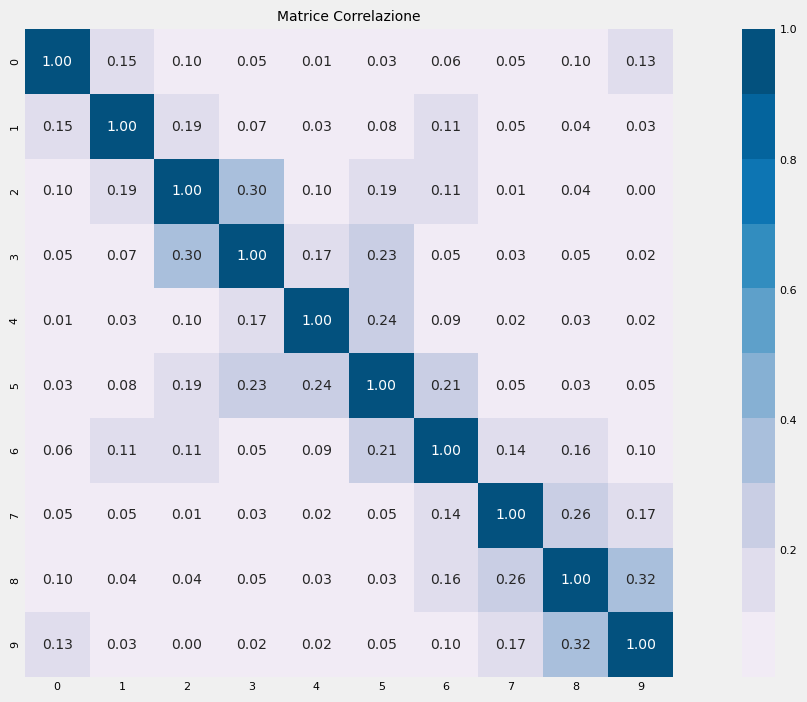

In [15]:
# Matrice di Correlazione delle prime 10 features
hm = sns.heatmap(corr_matrix.iloc[0:10,0:10], cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10} ,cmap=sns.color_palette("PuBu", 10))
plt.title('Matrice Correlazione')

$$ PCA $$

Per ridurre la dimensionalità del dataset abbiamo fatto $PCA$. Per capire quante componenti prendere, abbiamo fatto un’analisi della varianza delle nuove features ottenute, ovvero controlliamo l'andamento della varianza dei dati all'aumentare del numero di componenti. Come si vede dal grafico, la scelta migliore è prendere le 313 componenti principali. Così facendo abbiamo ridotto la dimensionalità del dataset.

Text(0, 0.5, 'cumulative explained variance')

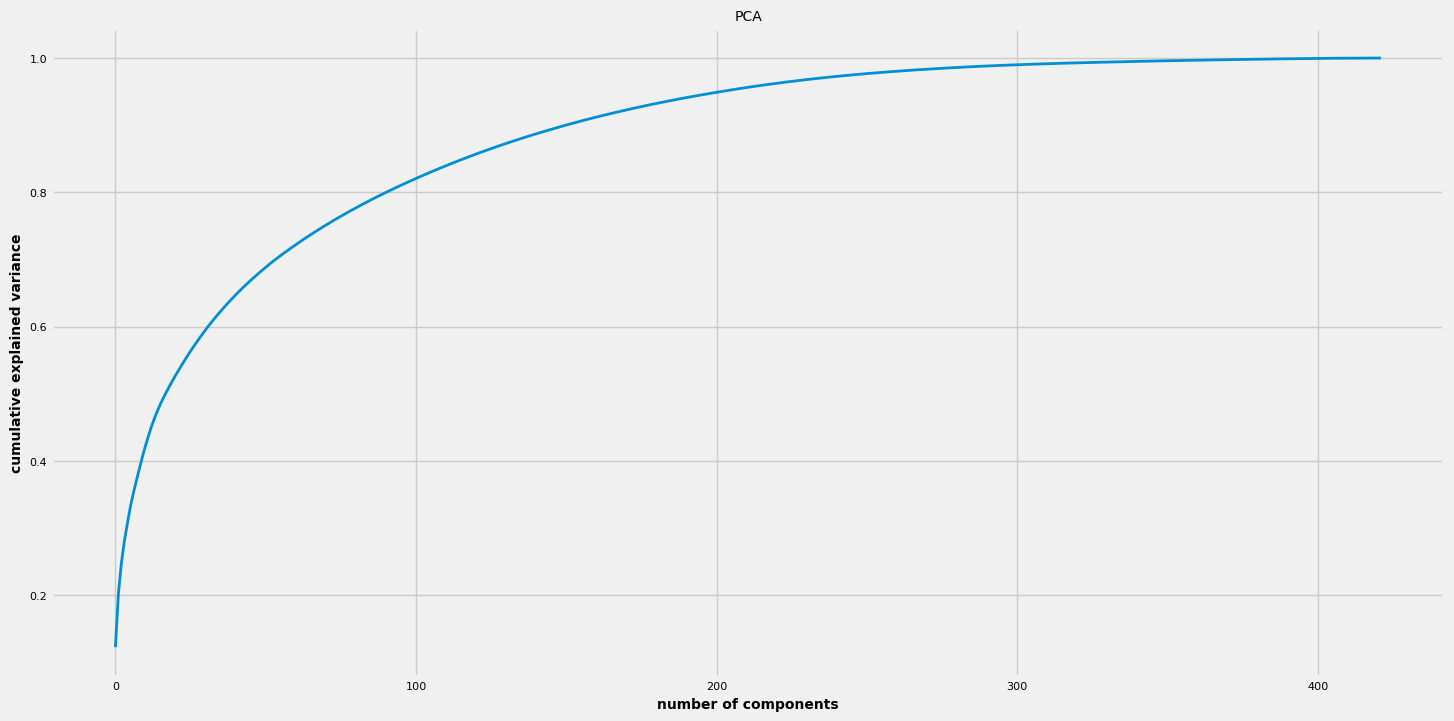

In [16]:
# PCA sul training set
train_x_pca = PCA(random_state=0).fit(train_x)
#Verifico l'andamento della varianza dei dati all'aumentare del numero di componenti
cumSumVariance = np.cumsum(train_x_pca.explained_variance_ratio_)
plt.plot(cumSumVariance)
plt.title('PCA')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [17]:
# Stampo numero di componenti che contengono il 99% della varianza del dataset
significantComponents = len(cumSumVariance[cumSumVariance<=0.99])
print('Il numero di componenti che contengono il 99% della varianza del dataset è: '
      ,significantComponents)

Il numero di componenti che contengono il 99% della varianza del dataset è:  300


In [18]:
# Eseguo la PCA su 313 componenti 
pca = PCA(n_components=significantComponents+1, random_state=0)
pca.fit(train_x)
# creo dei dataframe
train_x=pd.DataFrame(pca.transform(train_x))
test_x=pd.DataFrame( pca.transform(test_x))

$$ MUTUA \ INFORMAZIONE $$

Abbiamo fatto la $Mutua \ Informazione$ di due variabili casuali $X,Y$ che misura la mutua dipendenza delle due variabili. Intuitivamente, la $mutua \ informazione$ misura l'informazione che $X$ e $Y$ condividono. Essa quantifica la dipendenza tra la distribuzione congiunta delle variabili aleatorie $X$ e $Y$,  e la distribuzione congiunta nel caso in cui  $X$ e $Y$ fossero indipendenti. Quindi il ruolo della $Y$ è giocato dal $target$ del dataset, mentre la $X$ è una $feature$ del dataset. Abbiamo calcolato l’$informazione \ mutua$ di ogni feature rispetto al target. Più l’$informazione \ mutua$ è piccola allora più le variabili $X,Y$ sono indipendenti. Abbiamo così dedotto che ci sono delle feaures che non sono importanti in quanto hanno mutua informazione molto piccola.

$$ I(X,Y)= \sum_{x\in X}^{}\sum_{y\in Y}^{} p_{(X,Y)}(x,y)\log_{2}(\frac{p_{(X,Y)}(x,y)}{p_1(x)p_2(y)}) $$

In [19]:
#Identifico ogni classe con un numero da 0 a 7 (Mi serve per usare il comando della mutua informazione)
encode = LabelEncoder().fit_transform(train_y)
train_y_genre_encode = pd.DataFrame({'genre_top': encode[:]})

In [20]:
#Eseguo la mutua informazione:
mi = mutual_info_classif(train_x, train_y_genre_encode, random_state=0)
dmi = pd.DataFrame(mi, index=train_x.columns, columns=['mi']).sort_values(by='mi', ascending=True)
dmi.head()

,mi
287,0.0
221,0.0
144,0.0
140,0.0
260,0.0


In [21]:
print('Il numero di features con Mutua Informazione nulla rispetto il target è:'
      ,len(dmi[dmi['mi']==0.000000]))

Il numero di features con Mutua Informazione nulla rispetto il target è: 21


In [22]:
#Selezioniamo le variabili il cui valore mi=0 e eliminiamo da feat_df le rispettive colonne
indexCut = list(dmi[dmi['mi']==0.000000].index)
train_x=train_x.drop(indexCut, axis=1)
test_x=test_x.drop(indexCut, axis=1)

In [23]:
train_x.shape, test_x.shape

((6393, 280), (1601, 280))

$$ OUTLAIERS$$

Abbiamo affrontato il problema degli $outliers$ utilizzando i $box plot$. In figura sono rappresentati i $box plot$ di ogni features del dataset con il valore $whis= 1.5$. Tale valore determina la lunghezza dei $baffi$ del $box plot$. Gli elementi che stanno dall’intervallo 
$$[Q1 - whis*(Q3-Q1) , Q3 + whis*(Q3-Q1)]$$
dove $Q1, Q3$ sono rispettivamente il primo e terzo $quartile$, sono gli $outliers$. Quindi il valore $whis$ è quello che determina chi sono gli $outliers$ ovvero le istanze candidate ad essere eliminate dal dataset. Di seguito abbiamo fatto delle prove su quale fosse il valore migliore $whis$ da scegliere.


Si chiama $quantile \ di \ ordine \ \alpha $ di $ X $ variabile aleatoria, quel numero $ q_\alpha $ tale che: 
$$ \mathbb{P}(X\leq q_\alpha ) = \alpha $$

Text(0.5, 1.0, 'Boxplot')

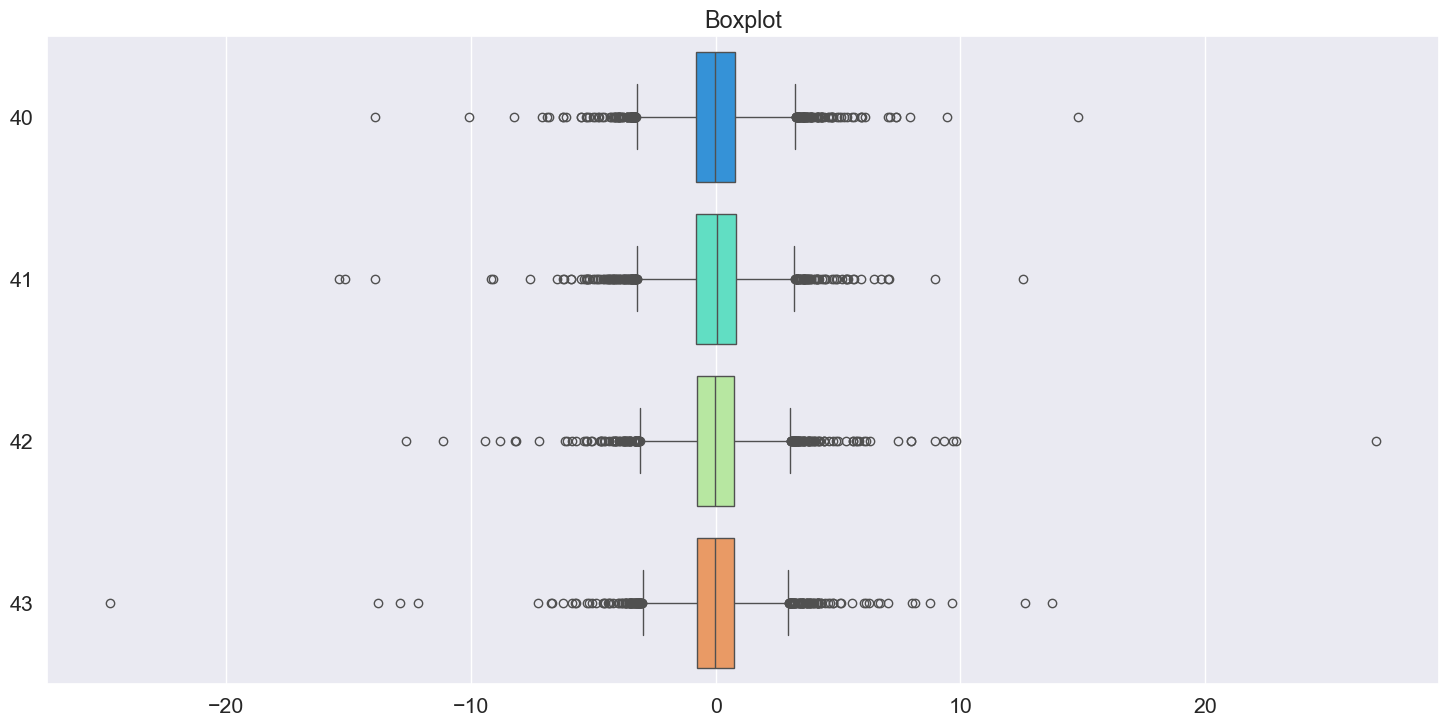

In [24]:
# Facciamo boxplot per capire chi sono gli outliers.
# Il parametro whis determina la lunghezza dei baffi

#plt.figure(figsize=(15,10))
sns.set(font_scale=1.4)

# default value whis= 1.5 
sns.boxplot(data=train_x.iloc[:,40:44], orient='h', palette='rainbow', whis=1.5)
plt.title('Boxplot')

In [25]:
# Eliminiamo gli outliers.
# Q1,Q3 sono il primo e terzo quartile
# Il parametro whis è scelto come quello del boxplot
Q1 = train_x.quantile(0.25)
Q3 = train_x.quantile(0.75)
IQR = Q3 - Q1
whis= 9

## contiamo gli outliers di ogni features
print('Questi sono gli outliers di ogni features con whiskers=1.5:  ')
((train_x < (Q1 - whis * IQR)) | (train_x > (Q3 + whis * IQR))).sum()


Questi sono gli outliers di ogni features con whiskers=1.5:  


0      0
1      0
2      2
3      0
4      2
      ..
295    1
296    0
297    0
298    0
300    0
Length: 280, dtype: int64

In [26]:
## Il codice seguente serve per eliminare gli outliers dal training set.
mask = ((train_x >= (Q1 - whis * IQR)) & (train_x <= (Q3 + whis * IQR)))
train_x = train_x[mask].dropna()
train_y = train_y.reset_index(drop=True)
train_y = train_y[train_x.index]

In [27]:
train_x.shape, train_y.shape

((6368, 280), (6368,))

$$ LEARNING $$

Applichiamo adesso alcuni metodi di learning, calcolando per ognuno la Matrice di confusione, la precision, la recall e l'F1 score.

In un processo di classificazione statistica, la $\textit Precision$ per una classe è il numero di veri positivi (ovvero il numero di oggetti etichettati correttamente come appartenenti alla classe) diviso il numero totale di elementi etichettati come appartenenti alla classe (ovvero la somma di veri positivi e falsi positivi, dove questi ultimi  sono gli oggetti etichettati erroneamente come appartenenti alla classe). 

$\textit Recall$  è il numero di veri positivi diviso il numero totale di elementi che effettivamente appartengono alla classe (ovvero la somma di veri positivi e falsi negativi, dove questi ultimi sono oggetti che non sono stati etichettati come appartenenti alla classe ma dovrebbero esserlo).

L'$\textit F1 score$ viene calcolato tramite la media armonica di $\textit Precision$  e $\textit Recall$ come mostrato in figura:

(-0.5, 1115.5, 408.5, -0.5)

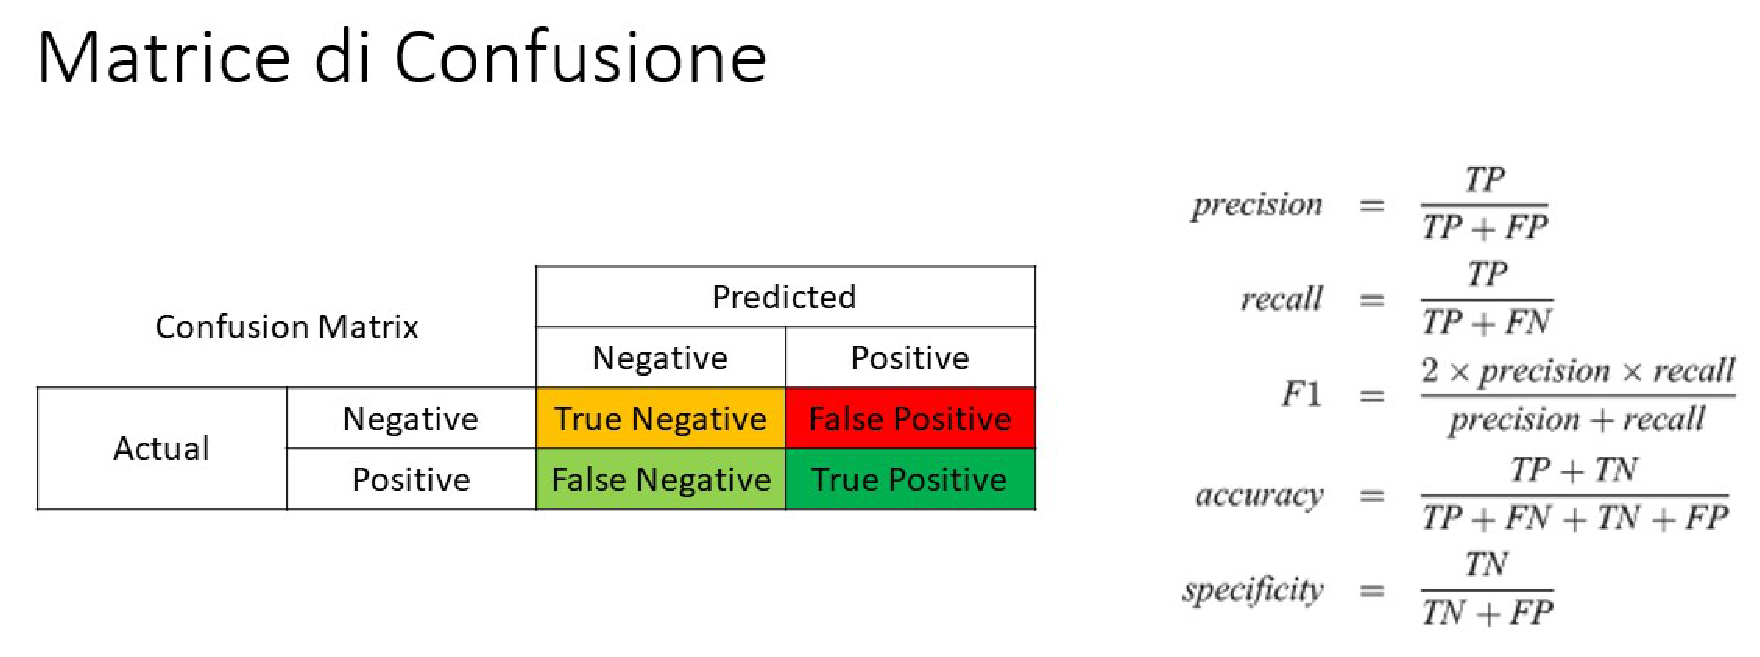

In [28]:
img=mpimg.imread('../pictures/Confusion_Matrix.jpg')
rcParams['figure.figsize'] = 20, 10
imgplot = plt.imshow(img)
plt.axis('off')

Abbiamo fatto due funzioni che utilizzeremo più volte quando applichiamo un modello:

 •	$param\_ selection()$  ci permette di fare grid search per il tuning degli iperparametri del modello che diamo in input a tale funzione
 
 •	$evaluate\_ classifier()$ utilizza il miglior modello ottenuto al termine della cross-validation per fare previsioni sui dati del test set


In [29]:
#Creiamo un dataframe in cui inseriamo i risultati di ogni metodo:
risultati = pd.DataFrame(columns = ['precision', 'recall', 'f1_score'])

In [30]:
def param_selection (clf, param_grid, X_train, Y_train):
    
    # , n_jobs=-1
    clf = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=5, refit=True, n_jobs=-1)
    clf.fit(X_train, Y_train)

    print("Best parameters:")
    print()
    print(clf.best_params_)
    print()
    print("F1-weighted:")
    print()
    print(clf.best_score_)
    print()

    return clf

In [31]:
delta=0.04

def upPop (Y_predictions):
    # il Test Set ha 1600 elementi
    Ypred = pd.Series(1600)
    i=0
    # notiamo che Y_predictions è una matrice 1600x8 che contiene
    # le probabilità di assegnazione ad una classe
    for vect in Y_predictions:      # ciclo for 1600 iterazioni
        vector=list(vect)   
#        vector[0]=vector[0]+0.015 #Se vogliamo migliorare Electronic
#        vector[1]=vector[1]+0.045 #Se vogliamo migliorare Experimental 

        vector[6]=vector[6]+delta #Per alzare la probabilità del genre 'Pop'
        indexMax = vector.index(max(vector))
        Ypred[i]=clf.classes_[indexMax] # clf è il classificatore che ci dà Y_predictions,
                                        # nel nostro caso è Softmax
        i=i+1
    return Ypred

In [32]:
def evaluate_classifier (classifier, name_clf, X_test, Y_test, boolProb):
    
    if boolProb:
        Y = classifier.predict_proba(X_test)    
        Y_predictions = upPop(Y)
    else:
        Y_predictions=classifier.predict(X_test)
    
    
    report = classification_report(Y_test,Y_predictions) 
    print(report)
    
    risultati.loc[name_clf]  = [report[627:631], report[637:641], report[647:651]]
    
    genres_List=["Folk", "Rock", "International", "Experimental", "Hip-Hop", "Pop","Electronic", "Instrumental"]
    mat = confusion_matrix(Y_test, Y_predictions, labels= genres_List)  

    plt.figure(figsize=(18,6))
    sns.set(font_scale=1.2)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
                cmap=sns.color_palette("PuBu", 10),
                xticklabels=genres_List, yticklabels=genres_List)
    plt.title('Matrice di confusione')
    plt.xlabel('true label')
    plt.ylabel('predicted label');   

$$ SVM \ Lineare \ OneVsRest $$

In [33]:
# in scores metteremo i risultati della cross validation
scores = []
# c_list = [0.001, 0.005, 0.008, 0.01, 0.03, 0.05 ,0.08, 0.1]
c_list = [0.001, 0.005]
# Facciamo cross validation:
for k in tqdm(c_list):
    clf_k=OneVsRestClassifier(svm.LinearSVC(C=k,random_state=0))
    score = cross_val_score(clf_k, train_x, train_y, cv=5, scoring='f1_weighted', n_jobs=-1)
    scores.append(score.mean())

scores

100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


[0.5010174015787063, 0.5054741440482834]

Text(0, 0.5, 'F1-Weighted')

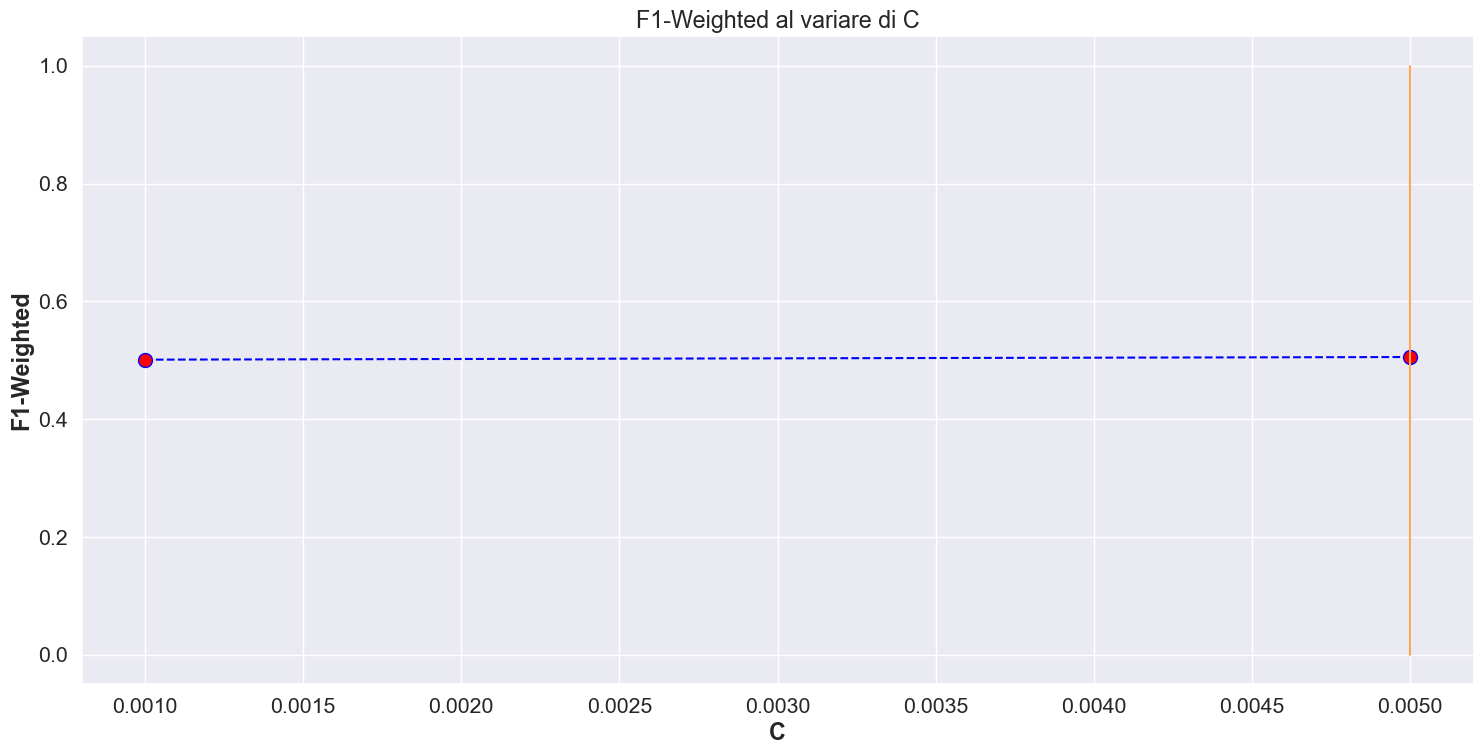

In [34]:
# bestC è il parametro migliore ottenuto dalla cross validation
indexMax = scores.index(max(scores))
bestC = c_list[indexMax]
# Stampiamo l'andamento di f1_macro al variare del parametro c di SVM
plt.figure(figsize=(16,8))
plt.plot(c_list, scores, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.plot([bestC, bestC], [0, 1.0],color='xkcd:pale orange')
plt.title('F1-Weighted al variare di C')
plt.xlabel('C')
plt.ylabel('F1-Weighted')

               precision    recall  f1-score   support

   Electronic       0.49      0.54      0.51       200
 Experimental       0.54      0.39      0.45       200
         Folk       0.58      0.63      0.60       200
      Hip-Hop       0.57      0.74      0.64       200
 Instrumental       0.48      0.56      0.51       201
International       0.57      0.60      0.58       200
          Pop       0.33      0.09      0.14       200
         Rock       0.57      0.72      0.64       200

     accuracy                           0.53      1601
    macro avg       0.51      0.53      0.51      1601
 weighted avg       0.51      0.53      0.51      1601



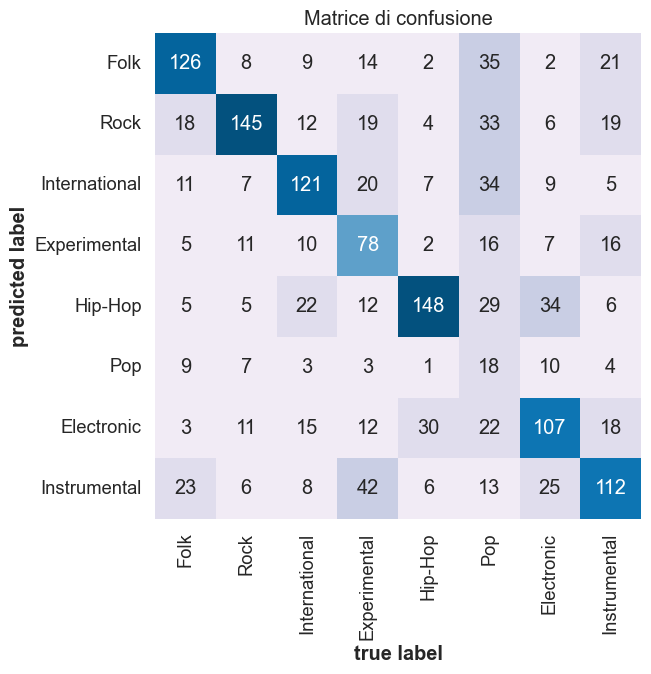

In [35]:
clf=OneVsRestClassifier(svm.LinearSVC(C=bestC,random_state=0)).fit(train_x,train_y)
evaluate_classifier(clf,'SVM Lineare OneVsRest', test_x, test_y, False)

$$ SVM \ Lineare \ OneVsOne $$

In [36]:
# in scores metteremo i risultati della cross validation
scores = []
c_list = [0.001, 0.005, 0.008, 0.01, 0.03, 0.05 ,0.08, 0.1]
# Facciamo cross validation:
for k in tqdm(c_list):
    clf_k=OneVsOneClassifier(svm.LinearSVC(C=k,random_state=0))
    score = cross_val_score(clf_k, train_x, train_y, cv=5, scoring='f1_weighted', n_jobs=-1)
    scores.append(score.mean())

scores

100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


[0.5298679807037162,
 0.5171804428337895,
 0.5150903971167604,
 0.5105428372865525,
 0.49963925057980846,
 0.49308857568882913,
 0.4882646331772558,
 0.484594184591238]

Text(0, 0.5, 'F1-Weighted')

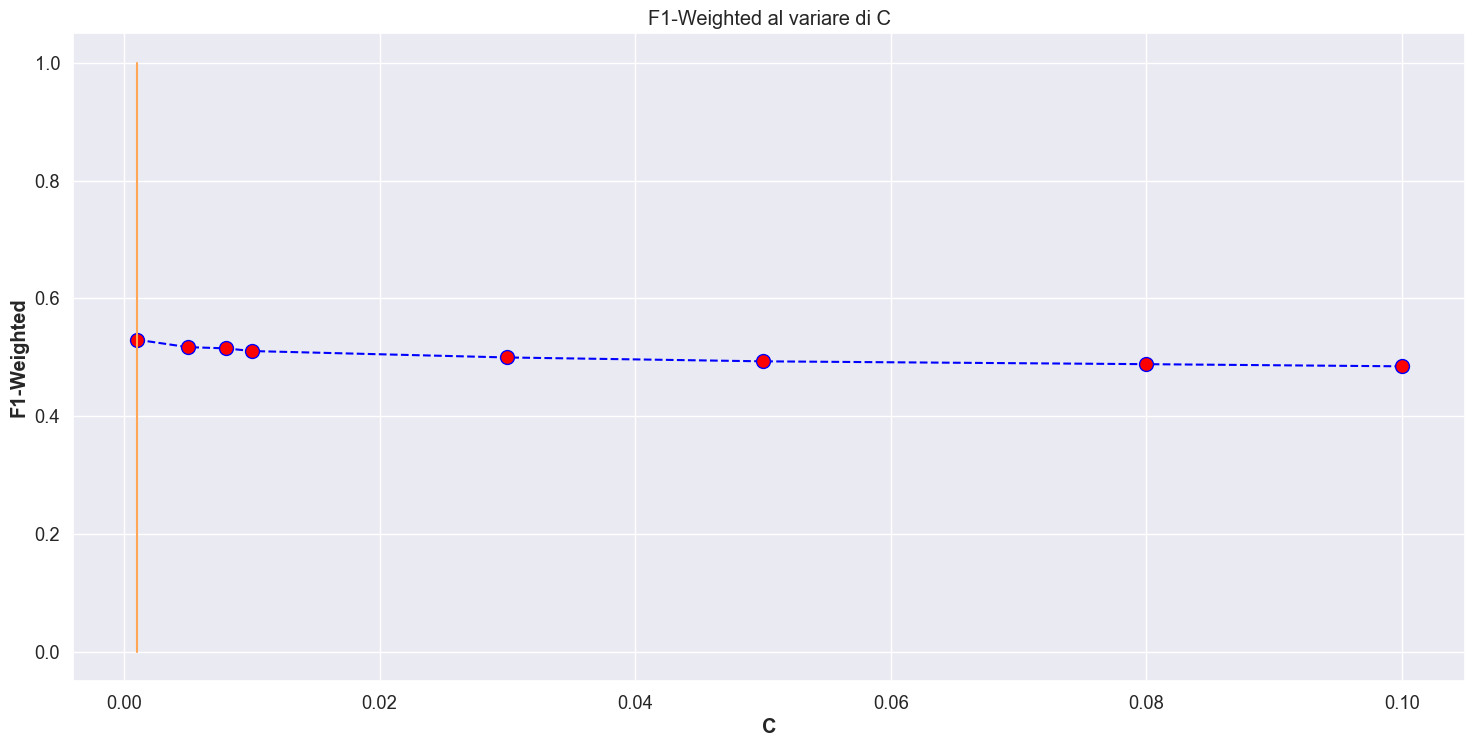

In [37]:
# bestC è il parametro migliore ottenuto dalla cross validation
indexMax = scores.index(max(scores))
bestC = c_list[indexMax]
# Stampiamo l'andamento di f1_macro al variare del parametro c di SVM
plt.figure(figsize=(16,8))
plt.plot(c_list, scores,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.plot([bestC, bestC], [0, 1.0],color='xkcd:pale orange')
plt.title('F1-Weighted al variare di C')
plt.xlabel('C')
plt.ylabel('F1-Weighted')

               precision    recall  f1-score   support

   Electronic       0.54      0.56      0.55       200
 Experimental       0.56      0.40      0.46       200
         Folk       0.62      0.62      0.62       200
      Hip-Hop       0.56      0.68      0.62       200
 Instrumental       0.52      0.58      0.55       201
International       0.56      0.58      0.57       200
          Pop       0.36      0.20      0.25       200
         Rock       0.54      0.71      0.62       200

     accuracy                           0.54      1601
    macro avg       0.53      0.54      0.53      1601
 weighted avg       0.53      0.54      0.53      1601



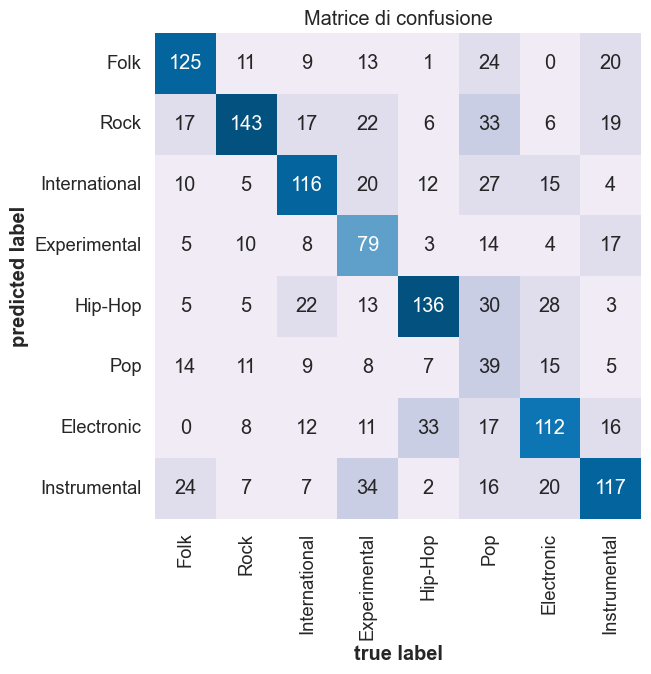

In [38]:
clf=OneVsOneClassifier(svm.LinearSVC(C=bestC,random_state=0)).fit(train_x,train_y)
evaluate_classifier(clf,'SVM Lineare OneVsOne', test_x, test_y, False)

$$ KNN $$

In [39]:
# Cross Validation
scores = []
# ks è il numero di vicini
ks=[1,4,8,10,20,30,40,80,100]
for k in tqdm(ks):
    score = cross_val_score(KNN(n_neighbors=k), train_x, train_y, cv=5, scoring='f1_weighted', n_jobs=-1)
    scores.append(score.mean())

scores

100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


[0.4261148434600871,
 0.4423748009409002,
 0.4367972066493128,
 0.4312741769731428,
 0.3996548223937677,
 0.3880874035333223,
 0.38214386159143576,
 0.3588310388660447,
 0.34969411354094854]

Text(0, 0.5, 'F1-Weighted')

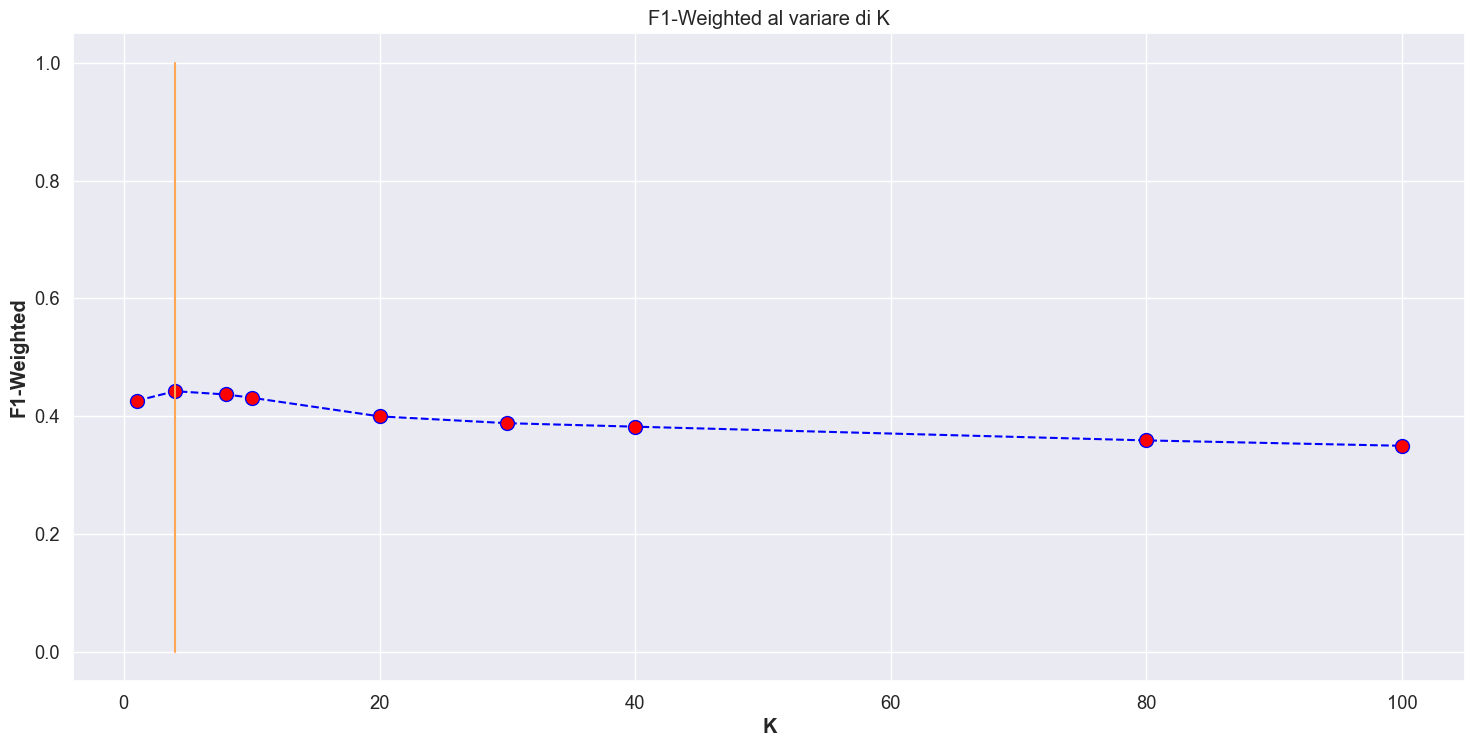

In [40]:
# bestC è il parametro migliore ottenuto dalla cross validation
indexMax = scores.index(max(scores))
bestK = ks[indexMax]
# Stampiamo l'andamento di f1_macro al variare del parametro c di SVM
plt.figure(figsize=(16,8))
plt.plot(ks, scores,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.plot([bestK, bestK], [0, 1.0],color='xkcd:pale orange')
plt.title('F1-Weighted al variare di K')
plt.xlabel('K')
plt.ylabel('F1-Weighted')

               precision    recall  f1-score   support

   Electronic       0.37      0.30      0.33       200
 Experimental       0.38      0.25      0.30       200
         Folk       0.55      0.58      0.56       200
      Hip-Hop       0.47      0.70      0.57       200
 Instrumental       0.65      0.40      0.50       201
International       0.50      0.65      0.56       200
          Pop       0.30      0.24      0.27       200
         Rock       0.49      0.62      0.55       200

     accuracy                           0.47      1601
    macro avg       0.47      0.47      0.46      1601
 weighted avg       0.47      0.47      0.46      1601



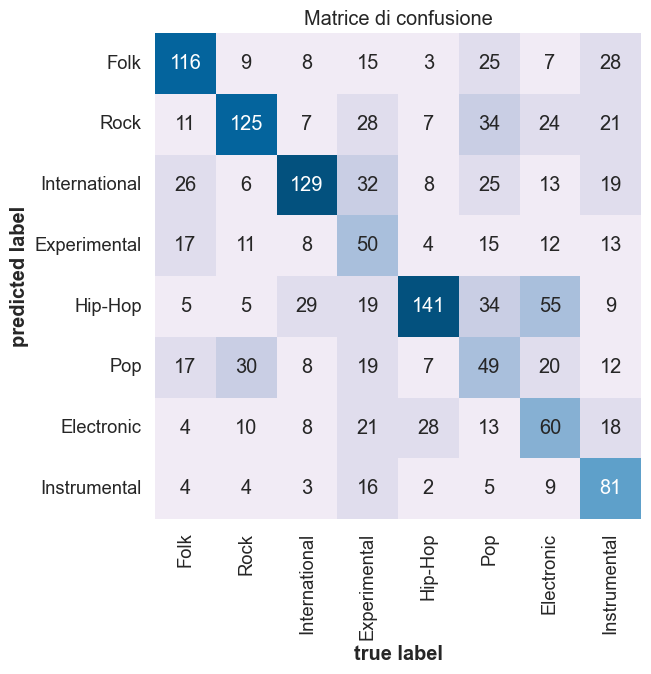

In [41]:
clf=KNN(n_neighbors=bestK).fit(train_x,train_y)
evaluate_classifier(clf,'KNN', test_x, test_y, False)

$$ SVM \ Kernel \ Gaussiano \ OneVsOne $$

Best parameters:

{'estimator__C': 10, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf', 'estimator__random_state': 0}

F1-weighted:

0.5570226165501391

               precision    recall  f1-score   support

   Electronic       0.56      0.54      0.55       200
 Experimental       0.54      0.48      0.51       200
         Folk       0.69      0.64      0.66       200
      Hip-Hop       0.65      0.71      0.68       200
 Instrumental       0.53      0.61      0.56       201
International       0.69      0.67      0.68       200
          Pop       0.37      0.34      0.35       200
         Rock       0.62      0.68      0.65       200

     accuracy                           0.58      1601
    macro avg       0.58      0.58      0.58      1601
 weighted avg       0.58      0.58      0.58      1601



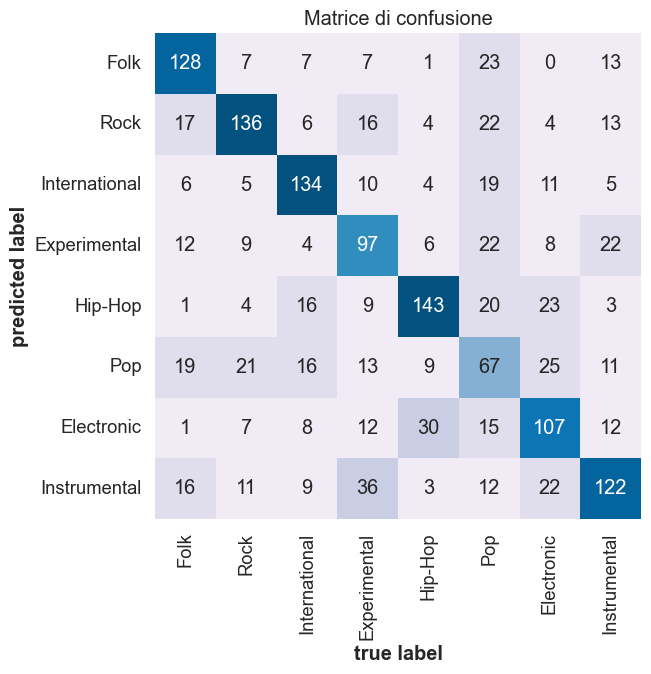

In [42]:
param_grid = [{'estimator__kernel': ['rbf'], 'estimator__gamma':[0.001, 0.01, 0.1, 1, 10], 
                   'estimator__C': [ 1, 10, 15] , 'estimator__random_state':[0]}]
    
clf = param_selection(OneVsOneClassifier(svm.SVC()), param_grid, train_x, train_y)
evaluate_classifier(clf, 'SVM Kernel Gaussiano OneVsOne', test_x, test_y, False)

$$ SVM \ Kernel \ Gaussiano \ OneVsRest $$

Best parameters:

{'estimator__C': 10, 'estimator__gamma': 0.001, 'estimator__kernel': 'rbf', 'estimator__random_state': 0}

F1-weighted:

0.560535919147899

               precision    recall  f1-score   support

   Electronic       0.54      0.54      0.54       200
 Experimental       0.54      0.45      0.49       200
         Folk       0.65      0.67      0.66       200
      Hip-Hop       0.63      0.76      0.69       200
 Instrumental       0.53      0.57      0.55       201
International       0.63      0.70      0.67       200
          Pop       0.45      0.25      0.32       200
         Rock       0.61      0.71      0.66       200

     accuracy                           0.58      1601
    macro avg       0.57      0.58      0.57      1601
 weighted avg       0.57      0.58      0.57      1601



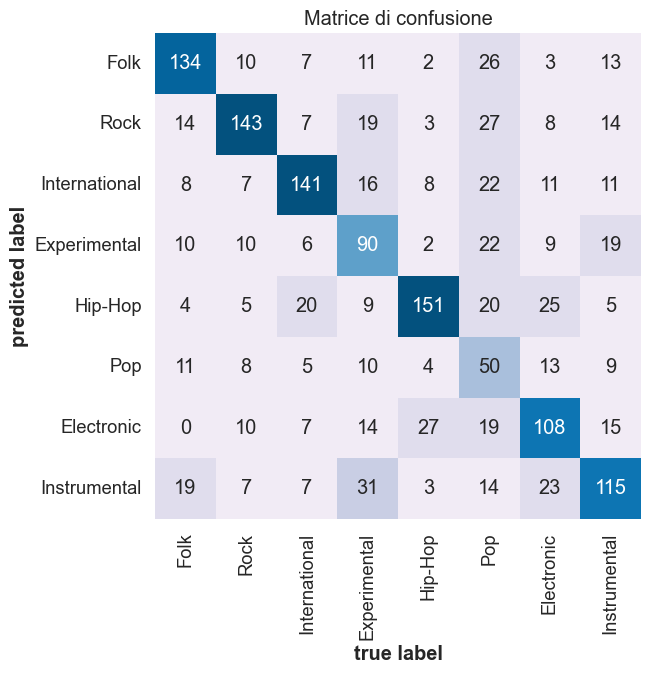

In [43]:
param_grid = [{'estimator__kernel': ['rbf'], 'estimator__gamma':[0.001, 0.01, 0.1, 1, 10], 
                   'estimator__C': [ 1, 10, 15] , 'estimator__random_state':[0]}]
    
clf = param_selection(OneVsRestClassifier(svm.SVC()), param_grid, train_x, train_y)
evaluate_classifier(clf, 'SVM Kernel Gaussiano OneVsRest', test_x, test_y, False)

$$SVM \ kernel \ Polinomiale \ OneVsOne$$

Best parameters:

{'estimator__C': 1, 'estimator__degree': 3, 'estimator__gamma': 0.01, 'estimator__kernel': 'poly', 'estimator__random_state': 0}

F1-weighted:

0.5390221977166602

               precision    recall  f1-score   support

   Electronic       0.52      0.45      0.48       200
 Experimental       0.70      0.32      0.44       200
         Folk       0.65      0.62      0.64       200
      Hip-Hop       0.63      0.68      0.65       200
 Instrumental       0.56      0.55      0.55       201
International       0.65      0.69      0.67       200
          Pop       0.33      0.47      0.39       200
         Rock       0.57      0.67      0.61       200

     accuracy                           0.56      1601
    macro avg       0.58      0.56      0.55      1601
 weighted avg       0.58      0.56      0.55      1601



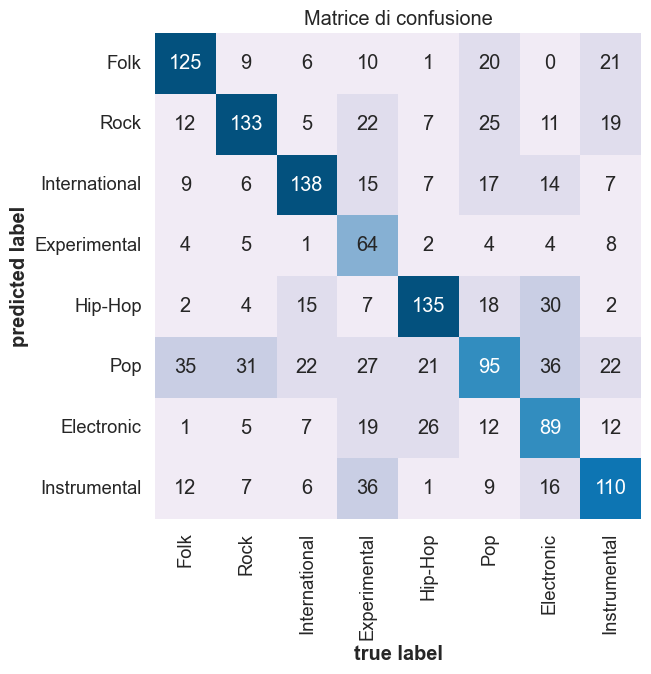

In [44]:
param_grid = [{'estimator__kernel': ['poly'], 'estimator__degree':[3,4,5],
                  'estimator__gamma':[0.1,0.01,0.001,1,10], 
                  'estimator__C': [ 1, 10, 100] , 'estimator__random_state':[0] }]

clf = param_selection(OneVsOneClassifier(svm.SVC()),param_grid,train_x, train_y)
evaluate_classifier(clf,'SVM Kernel Polinomiale OneVsOne', test_x, test_y, False)

$$  SVM \ Kernel \ Polinomiale \ OneVsRest $$

Best parameters:

{'estimator__C': 100, 'estimator__degree': 3, 'estimator__gamma': 0.001, 'estimator__kernel': 'poly', 'estimator__random_state': 0}

F1-weighted:

0.5486248422888036

               precision    recall  f1-score   support

   Electronic       0.56      0.51      0.53       200
 Experimental       0.63      0.36      0.46       200
         Folk       0.62      0.68      0.65       200
      Hip-Hop       0.58      0.72      0.64       200
 Instrumental       0.56      0.57      0.57       201
International       0.60      0.69      0.64       200
          Pop       0.42      0.27      0.33       200
         Rock       0.54      0.73      0.62       200

     accuracy                           0.57      1601
    macro avg       0.56      0.57      0.55      1601
 weighted avg       0.56      0.57      0.55      1601



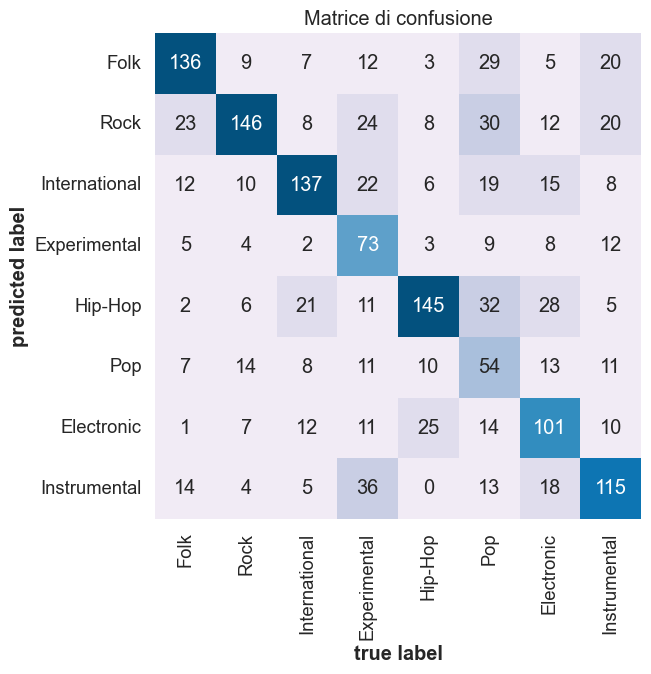

In [45]:
param_grid = [{'estimator__kernel': ['poly'], 'estimator__degree':[3,4,5],
                  'estimator__gamma':[0.1,0.01,0.001,1,10], 
                  'estimator__C': [ 1, 10, 100] , 'estimator__random_state':[0] }]

clf = param_selection(OneVsRestClassifier(svm.SVC()),param_grid,train_x, train_y)
evaluate_classifier(clf,'SVM Kernel Polinomiale OneVsRest', test_x, test_y, False)

$$ Random \ Forest $$

$param\_ grid$:
 - max_depth è la massima profondità degli alberi
 - max_features è il numero di features che vengono considerate per fare gli split
 - min_samples_leaf è il numero minimo di elementi in un nodo foglia
 - n_estimators è il numero di alberi della foresta
 - criterion è la funzione che misura la qualità di uno split
 - warm_start se è True allora riusa la soluzione della precedente chiamata 

Best parameters:

{'criterion': 'gini', 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 4, 'n_estimators': 350, 'random_state': 0, 'warm_start': False}

F1-weighted:

0.4735490549135834

               precision    recall  f1-score   support

   Electronic       0.45      0.47      0.46       200
 Experimental       0.60      0.30      0.41       200
         Folk       0.55      0.57      0.56       200
      Hip-Hop       0.50      0.71      0.59       200
 Instrumental       0.47      0.61      0.53       201
International       0.61      0.47      0.53       200
          Pop       0.37      0.14      0.21       200
         Rock       0.48      0.72      0.58       200

     accuracy                           0.50      1601
    macro avg       0.50      0.50      0.48      1601
 weighted avg       0.50      0.50      0.48      1601



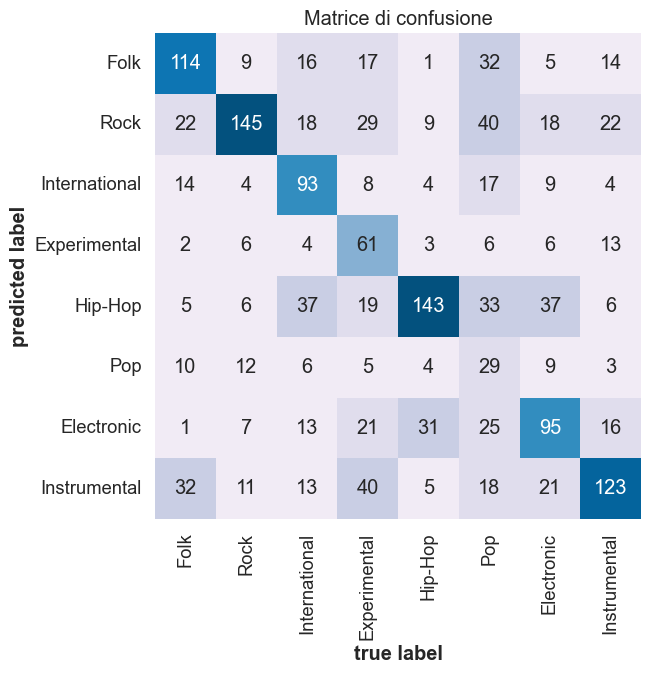

In [46]:
param_grid = {  'max_depth': [20,30,40],  'max_features': [4,6,8],  'min_samples_leaf': [2, 3, 4],
              'n_estimators': [200,300,350], 'random_state':[0], 
              'criterion':["gini","entropy"], 'warm_start': [False, True]}

clf = param_selection(RandomForestClassifier(), param_grid, train_x, train_y)
evaluate_classifier(clf, 'Random Forest', test_x, test_y, False)

$$ Adaboost  $$

Best parameters:

{'algorithm': 'SAMME', 'estimator__max_depth': 3, 'n_estimators': 350, 'random_state': 0}

F1-weighted:

0.4386470656892332

               precision    recall  f1-score   support

   Electronic       0.41      0.34      0.38       200
 Experimental       0.39      0.36      0.38       200
         Folk       0.57      0.43      0.49       200
      Hip-Hop       0.51      0.59      0.55       200
 Instrumental       0.47      0.49      0.48       201
International       0.42      0.38      0.40       200
          Pop       0.24      0.34      0.28       200
         Rock       0.54      0.52      0.53       200

     accuracy                           0.43      1601
    macro avg       0.44      0.43      0.43      1601
 weighted avg       0.44      0.43      0.43      1601



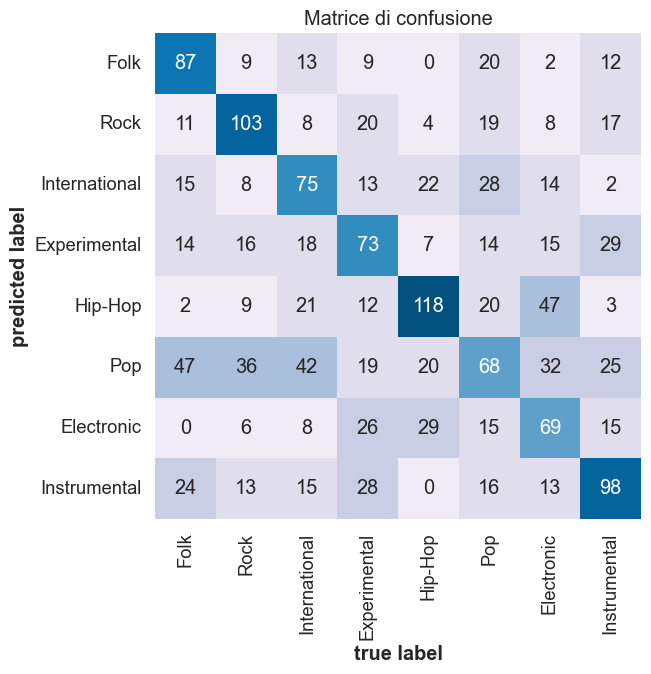

In [47]:
# 'algorithm':['SAMME','SAMME.R'] sono i possibili algoritmi per il boosting
param_grid = [{'n_estimators':[200, 300, 350], 'random_state':[0], 'algorithm':['SAMME','SAMME.R'],
                      'estimator__max_depth': [2,3]}]

clf = param_selection(AdaBoostClassifier(estimator=DecisionTreeClassifier()), param_grid, train_x, train_y)
evaluate_classifier(clf, 'AdaBoost DecisionTree', test_x, test_y, False)

$$ Gradient \ Boosting $$

$param\_ grid$:
 - n_estimators è il numero di alberi
 - max_depth è la massima profondità degli alberi
 - subsample è la frazione di campioni usata da ognuno dei base learners per fare apprendimento. Se è più piccola di 1 allora Stochastic Gradient Boosting

Best parameters:

{'max_depth': 4, 'n_estimators': 300, 'random_state': 0, 'subsample': 0.75}

F1-weighted:

0.5199559343775307

               precision    recall  f1-score   support

   Electronic       0.46      0.47      0.47       200
 Experimental       0.52      0.41      0.46       200
         Folk       0.62      0.61      0.62       200
      Hip-Hop       0.56      0.65      0.60       200
 Instrumental       0.49      0.56      0.52       201
International       0.60      0.55      0.57       200
          Pop       0.31      0.27      0.29       200
         Rock       0.56      0.61      0.59       200

     accuracy                           0.52      1601
    macro avg       0.51      0.52      0.51      1601
 weighted avg       0.51      0.52      0.51      1601



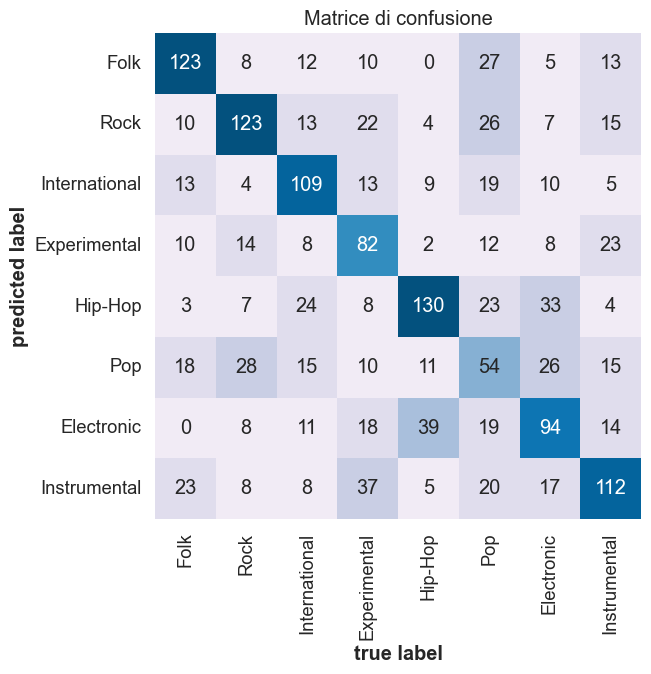

In [49]:
param_grid = [{'n_estimators': [200, 300], 'max_depth': [3, 4], 
                   'subsample':[.75,1],'random_state':[0]}]

clf = param_selection(GradientBoostingClassifier(), param_grid, train_x, train_y)
evaluate_classifier(clf, 'Gradient Boosting', test_x, test_y, False) 

$$ Softmax $$

$param\_ grid$:
 - solver è l'algoritmo usato per l'ottimizzazione
 - penalty è la norma usata nel termine di penalizzazione

Best parameters:

{'C': 0.01, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg', 'warm_start': False}

F1-weighted:

0.5239554492164606

               precision    recall  f1-score   support

   Electronic       0.51      0.52      0.52       200
 Experimental       0.52      0.41      0.46       200
         Folk       0.61      0.60      0.61       200
      Hip-Hop       0.58      0.70      0.64       200
 Instrumental       0.51      0.55      0.53       201
International       0.52      0.56      0.54       200
          Pop       0.32      0.21      0.25       200
         Rock       0.58      0.69      0.63       200

     accuracy                           0.53      1601
    macro avg       0.52      0.53      0.52      1601
 weighted avg       0.52      0.53      0.52      1601



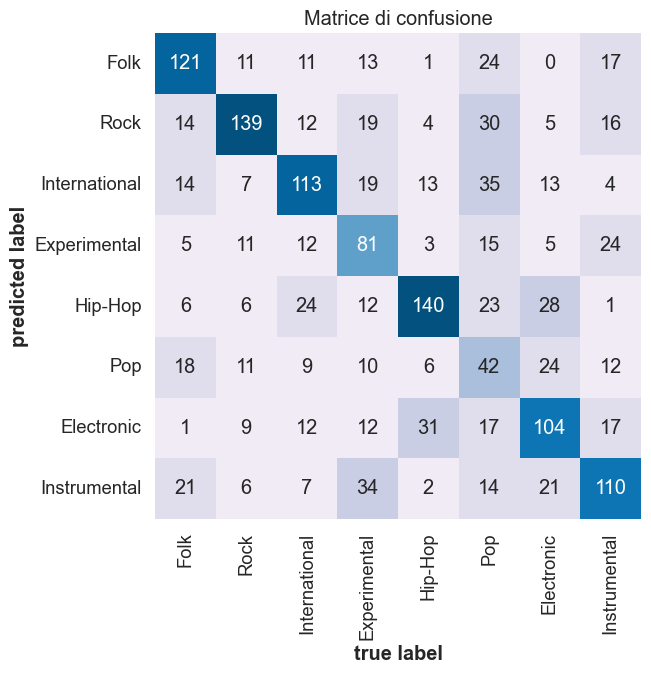

In [50]:
param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10 , 100, 1000, 2000], 'penalty': ['l1','l2'], 
                  'warm_start':[False,True], 'random_state':[0],  'solver':['newton-cg', 'lbfgs']}]

clf = param_selection(LogisticRegression(), param_grid, train_x, train_y)
evaluate_classifier(clf, 'Softmax', test_x, test_y, False)

Best parameters:

{'C': 0.01, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg', 'warm_start': False}

F1-weighted:

0.5239554492164606

               precision    recall  f1-score   support

   Electronic       0.52      0.52      0.52       200
 Experimental       0.53      0.41      0.46       200
         Folk       0.63      0.59      0.61       200
      Hip-Hop       0.59      0.69      0.64       200
 Instrumental       0.51      0.54      0.53       201
International       0.54      0.56      0.55       200
          Pop       0.34      0.30      0.32       200
         Rock       0.60      0.68      0.63       200

     accuracy                           0.54      1601
    macro avg       0.53      0.54      0.53      1601
 weighted avg       0.53      0.54      0.53      1601



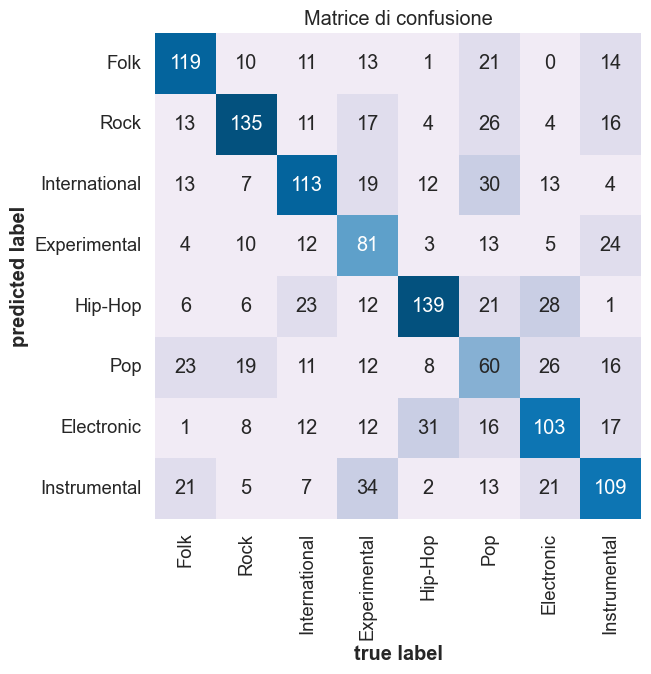

In [51]:
param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10 , 100, 1000, 2000], 'penalty': ['l1','l2'], 
               'warm_start':[False,True], 'random_state':[0],  'solver':['newton-cg', 'lbfgs']}]

clf = param_selection(LogisticRegression(), param_grid, train_x, train_y)
evaluate_classifier(clf, 'Softmax upPop', test_x, test_y, True)

In [52]:
risultati

,precision,recall,f1_score
SVM Lineare OneVsRest,0.51,0.53,0.51
SVM Lineare OneVsOne,0.53,0.54,0.53
KNN,0.47,0.47,0.46
SVM Kernel Gaussiano OneVsOne,0.58,0.58,0.58
SVM Kernel Gaussiano OneVsRest,0.57,0.58,0.57
SVM Kernel Polinomiale OneVsOne,0.58,0.56,0.55
SVM Kernel Polinomiale OneVsRest,0.56,0.57,0.55
Random Forest,0.50,0.50,0.48
AdaBoost DecisionTree,0.44,0.43,0.43
Gradient Boosting,0.51,0.52,0.51


$$ Analisi \ grafica \ delle \ classi $$

Consideriamo il nostro training set ottenuto dopo aver fatto Data Pre-Processing descritta precedentemente e prendiamo le 3 componenti principali per mettere in risalto quanto i generi classificati peggio dai nostri modelli siano mischiati tra loro ed i generi classificati meglio sono distinguibili.

In [53]:
train_pca = train_x.take([0, 1, 2], axis=1)

#train_y = train_y.reset_index(drop=True)
train = train_pca.join(train_y) 

In [54]:
train_classi_migliori = train[(train['genre_top']=='Hip-Hop') | (train['genre_top']=='International')]

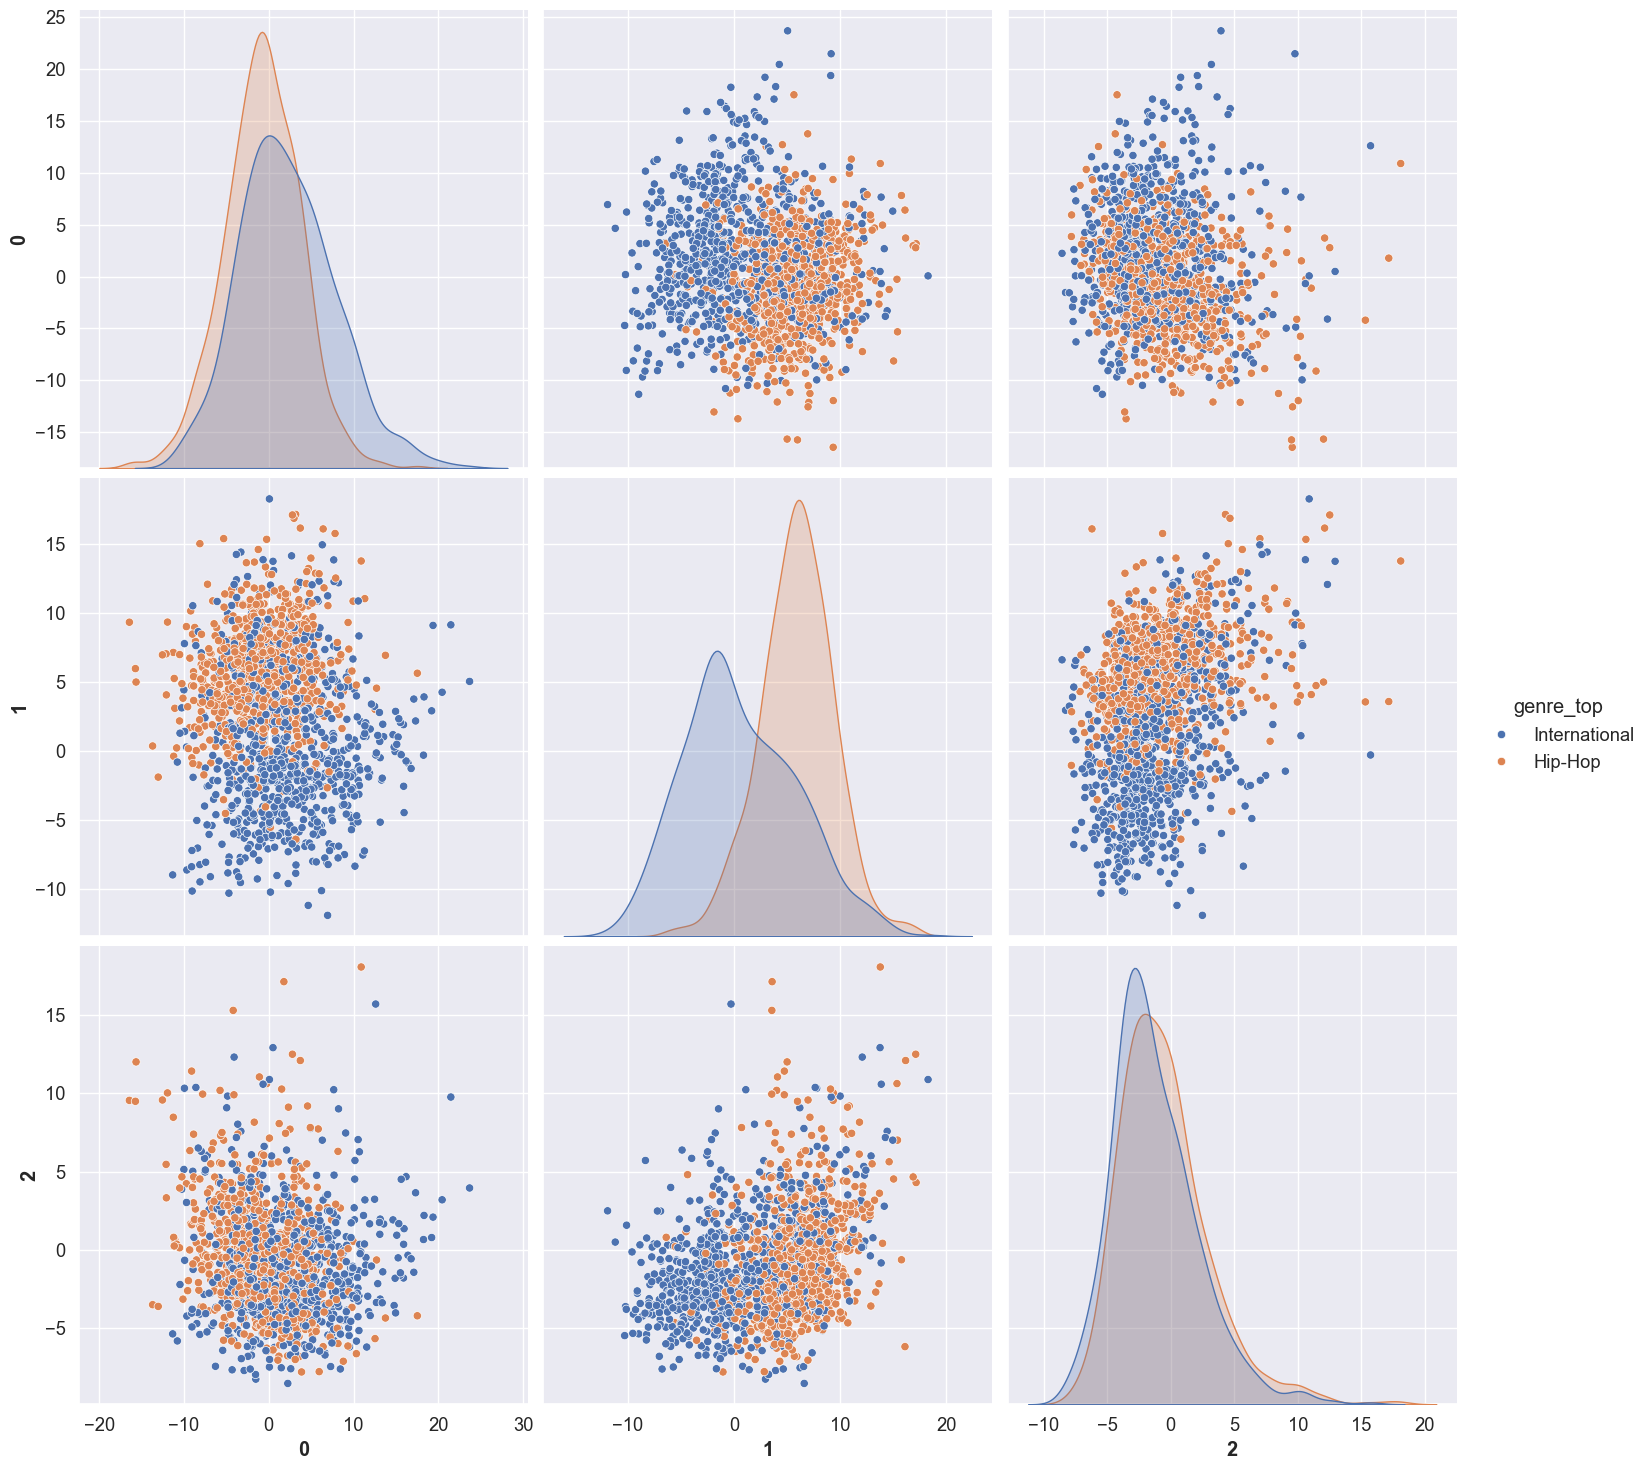

In [55]:
sns.pairplot(train_classi_migliori, hue='genre_top', height = 5)

In [56]:
train_classi_peggiori = train[(train['genre_top']=='Pop') | (train['genre_top']=='Rock')]

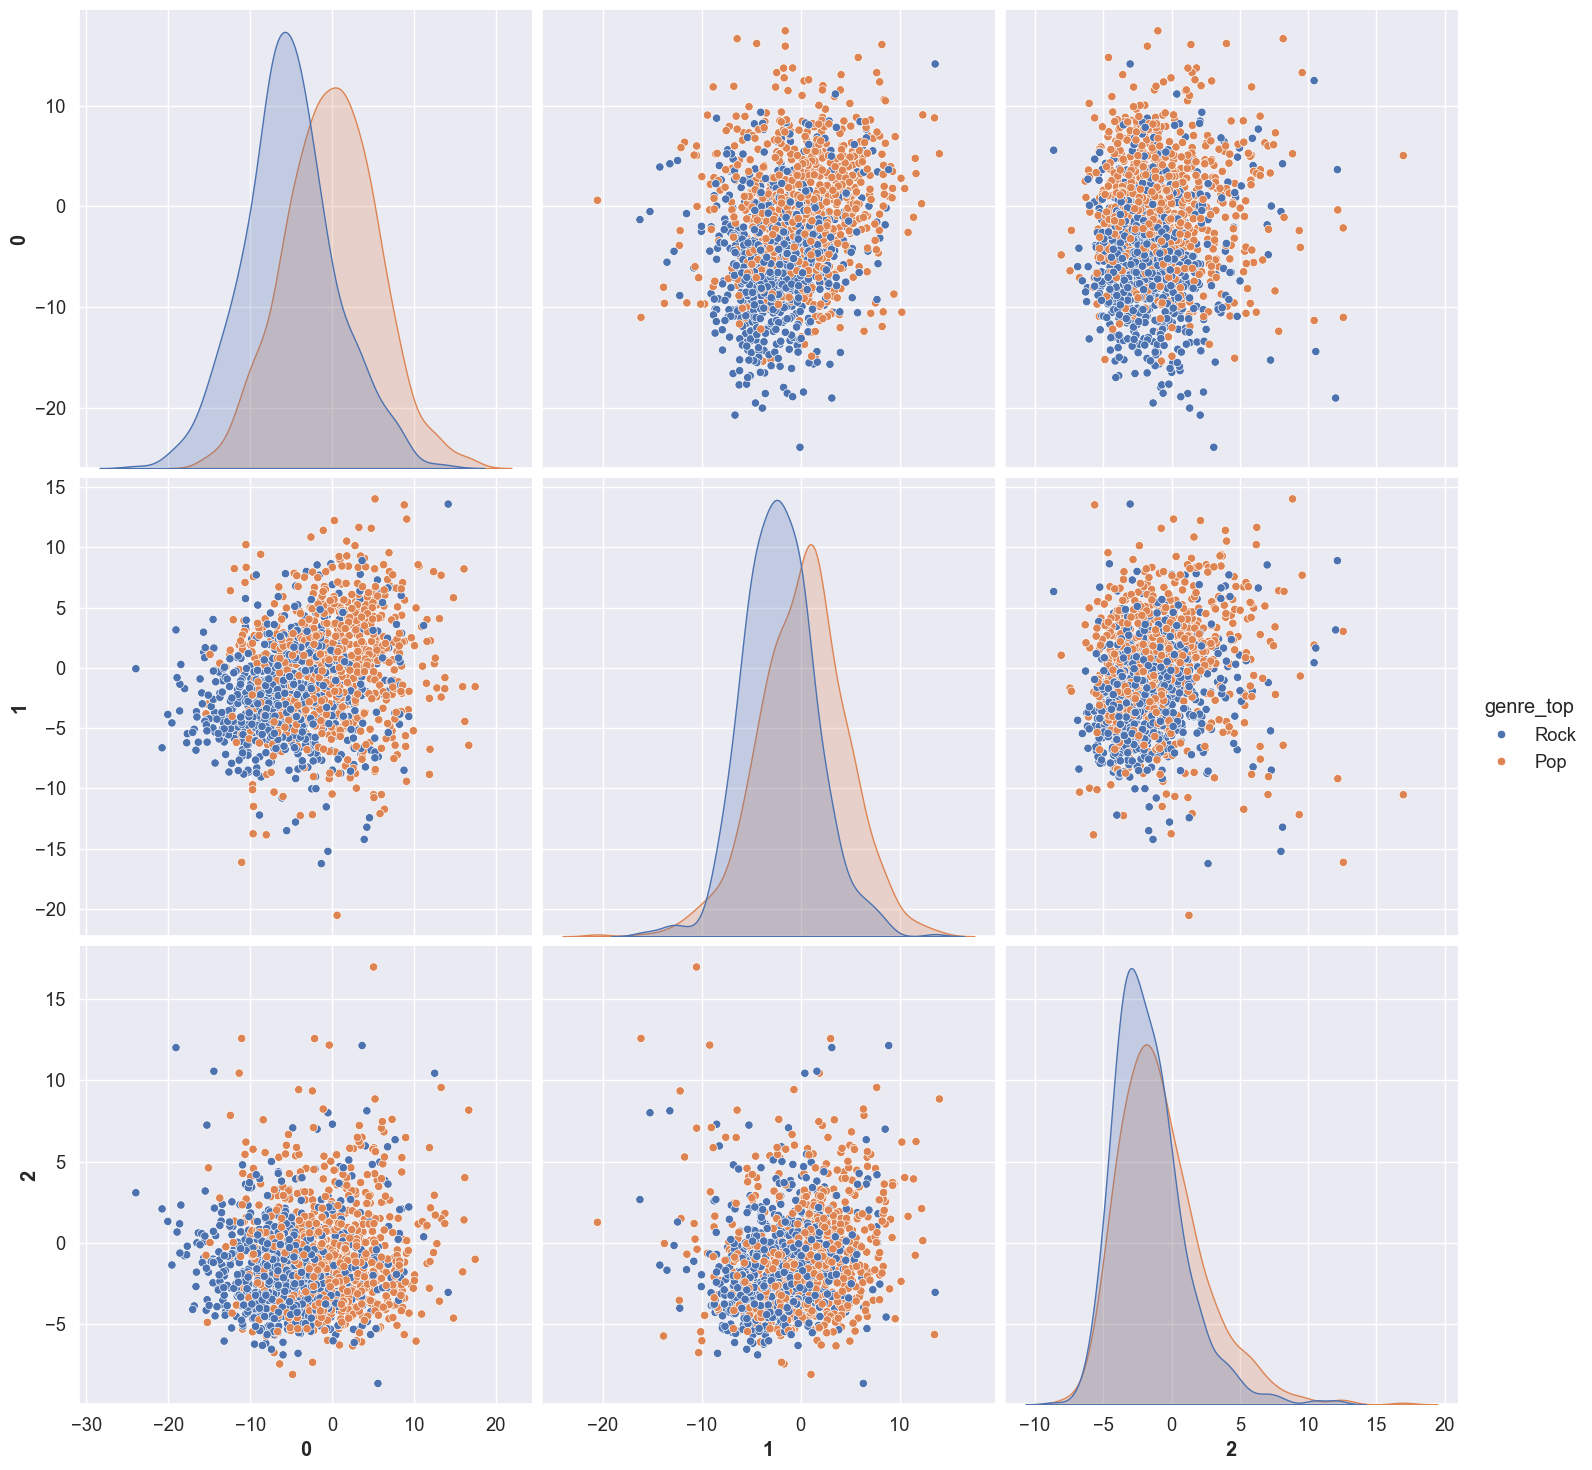

In [57]:
sns.pairplot(train_classi_peggiori, hue='genre_top', height = 5)